<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Coordinate-Descent-for-Lasso" data-toc-modified-id="Coordinate-Descent-for-Lasso-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Coordinate Descent for Lasso</a></span><ul class="toc-item"><li><span><a href="#Data-Set-and-Programming-Problem-Overview" data-toc-modified-id="Data-Set-and-Programming-Problem-Overview-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data Set and Programming Problem Overview</a></span></li><li><span><a href="#Experiments-with-the-shooting-algorithm" data-toc-modified-id="Experiments-with-the-shooting-algorithm-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Experiments with the shooting algorithm</a></span></li></ul></li></ul></div>

# Homework 2: Lasso Regression

## Coordinate Descent for Lasso

The Lasso optimization problem can be formulated as: $$ \hat{w} \in argmin_{w \in R^d} \sum_{i=1}^m(h_w(x_i) - y_i)^2 + \lambda\|w\|_1 $$
where $h_w(x) = w^Tx$ and $\|w\|_1 = \sum_{i=1}^d |w_i| $.  
To align with Murphy's formulation below here the total square loss rather than the average square loss is used in the objective function.  
Since the $l_1$ regularization term in the objective functionis non-differentiable, it's not immediately clear how gradient descent or SGD could be used to solve this optimization problem directly.  
Another approach to solving optimization problems is coordinate descent, in which at each step we optimize over one component of the unknown parameter vector, fixing all other components. The descent path so obtained is a sequence of steps, each of which is parallel to a coordinate axis in $R^d$, hence the name. It turns out that for the Lasso optimization problem, we can find a closed form solution for optimization over a single component fixing all other components. This gives us the following algorithm, known as the shooting algorithm:

![Coordinate descent for Lasso](Images/Lasso.png)  
(Source: Murphy, Kevin P. Machine learning: a probabilistic perspective. MIT press, 2012)

The "soft thresholding" function is defined as $$soft(a, \delta) = sign(a)(|a| - \delta)_+,$$
for any $a, \delta \in R$.

NOTE: Algorithm 13.1 does not account for the case that $a_j = c_j = 0$, which occurs when the *j*th column of X is identically 0. One can either eliminate the column (as it cannot possibly help the solution), or you can set $w_j = 0$ in that case since it is, as you can easily verify, the coordinate minimizer. Note also that Murphy is suggesting to initialize the optimization with the ridge regession solution. Although theoretically this is not necessary (with exact computations and enough time, coordinate descent will converge for lasso from any starting point), in practice it’s helpful to start as close to the solution as we’re able.

There are a few tricks that can make selecting the hyperparameter λ easier and faster. First, as we’ll see in a later problem, you can show that for any $\lambda ≥ 2\|X^T (y − \bar{y})\|_\infty$, the estimated weight vector $\hat{w}$ is entirely zero, where $\bar{y}$ is the mean of values in the vector $y$, and $\| · \|_\infty$ is the infinity norm (or supremum norm), which is the maximum over the absolute values of the components of a vector. Thus we need to search for an optimal $\lambda$ in $[0, \lambda_{max} ]$, where $\lambda_{max} = 2\|X^T (y − \bar{y})\|_\infty$ (Note: This expression for $ \lambda_{max} $ assumes we have an unregularized bias term in our model. That is, our decision functions are of the form $h_{w,b}(x) = w^T x + b$. In our the experiments, we do not have an unregularized bias term, so we should use $\lambda_{max} = 2\|X^T y\|_\infty$.)
The second trick is to use the fact that when $\lambda$ and $\lambda'$ are close, the corresponding solutions $\hat{w}(\lambda)$ and $\hat{w}(\lambda')$ are also close. Start with $\lambda = \lambda_{max}$, for which we know $\hat{w}(\lambda_{max}) = 0$. You can run the optimization anyway, and initialize the optimization at $w = 0$. Next, $\lambda$ is reduced (e.g. by a constant factor close to 1), and the optimization problem is solved using the previous optimal point as the starting point. This is called **warm starting** the optimization. The technique of computing a set of solutions for a chain of nearby $\lambda$'s is called a **continuation** or **homotopy method**. The resulting set of parameter values $\hat{w}(\lambda)$ as $\lambda$ ranges over $[0, \lambda_{max} ]$ is known as a **regularization path**.

### Data Set and Programming Problem Overview

- For the experiments, we are generating some artifical data using code in the file setup_problem.py
- We are considering the regression setting with the 1-dimensional input space $R$. 
- An image of the training data, along with the target function (i.e. the Bayes prediction function for the square loss function) is shown in Figure 1 below.

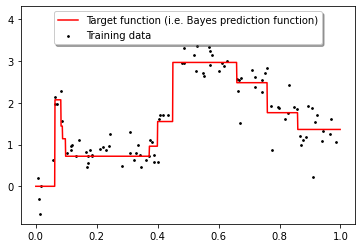

In [1]:
from setup_problem import *
%run setup_problem.py

- The target function is a highly nonlinear function of the input. 
- To handle this sort of problem with linear hypothesis spaces, we will need to create a set of features that perform nonlinear transforms of the input.
- A detailed description of the technique we will use can be found in the Jupyter notebook basis-fns.ipynb.

- In this assignment, we are providing you with a function that takes care of the featurization. This is the “featurize” function, returned by the generate_problem function in setup_problem.py.
- The generate_problem function also gives the true target function, which has been constructed to be a sparse linear combination of our features.
- The coefficients of this linear combination are also provided by generate_problem, so you can compare the coefficients of the linear functions you find to the target function coefficients.
- The generate_problem function also gives you the train and validation sets that you should use.

### Experiments with the shooting algorithm

<span style="color:blue">  1. The algorithm as described above is not ready for a large dataset (at least if it has being implemented in Python) because of the implied loop in the summation signs for the expressions for $a_j$ and $c_j$. Give an expression for computing $a_j$ and $c_j$ using matrix and vector operations, without explicit loops. This is called “vectorization” and can lead to dramatic speedup when implemented in languages such as Python, Matlab, and R. Write your expressions using $X, w, y = (y_1, . . . , y_n)^T$ (the column vector of responses), $X_{·j}$ (the jth column of $X$, represented as a column matrix), and $w_j$ (the jth coordinate of $w$ – a scalar). </span>

$$ a_j = 2X_{·j}^TX_{·j} $$   
$$c_j = 2X_{·j}^T(y-Xw + w_j*X_{·j})$$

<span style="color:blue"> 2. Write a function that computes the Lasso solution for a given $\lambda$ using the shooting algorithm described above. For convergence criteria, continue coordinate descent until a pass through the coordinates reduces the objective function by less than $10^{−8}$, or you have taken 1000 passes through the coordinates. Compare performance of cyclic coordinate descent to randomized coordinate descent, where in each round we pass through the coordinates in a different random order (for your choices of $\lambda$). Compare also the solutions attained (following the convergence criteria above) for starting at 0 versus starting at the ridge regression solution suggested by Murphy (again, for your choices of $\lambda$). If you like, you may adjust the convergence criteria to try to attain better results (or the same results faster). </span>

In [2]:
x_train, y_train, x_test, y_test, target_fn, coefs_true, featurize = load_problem('lasso_data.pickle')

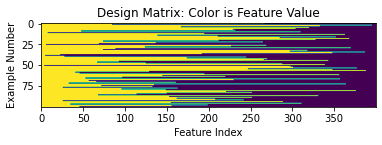

In [3]:
# Generate features
X_train = featurize(x_train)
X_test = featurize(x_test)

#Visualize training data
fig, ax = plt.subplots()
ax.imshow(X_train)
ax.set_title("Design Matrix: Color is Feature Value")
ax.set_xlabel("Feature Index")
ax.set_ylabel("Example Number")
plt.show(block=False)

In [4]:
#Cyclic coordinate descent

#Soft threshold function:
def soft(a,d):
    if a < -d:
        return (a + d)
    elif a > d:
        return (a - d)
    else:
        return 0

#Cyclic coordinate descent with a closed form solution:
def cyclic_coord_descent(X_train, l1_reg=1, num_iters=1000, tol = 1e-8):
    """
    cyclic_coord_descent implements the cyclic coordinate descent algorithm. At each iteration,
    the algorithm increments the index j of the coordinate to minimize the weight vector over. 
    In each step, the coefficent w[j] is updated with the minimizer corresponding to that index, using 
    the soft threshold function. 
    The function takes as input the training dataset, the hyperparameter lambda (l1_reg), the maximum number of iterations,
    and the tolerance level. The stopping criteria are the tolerance level (until a pass  pass through the coordinates 
    reduces the objective function by less than 10^−8) and the max number of iterations.
    """
    
    #Number of training examples, number of features
    m, D = X_train.shape
    
    #Initialize weights vector
    w_new = np.zeros(D)
    
    #Initialize a and c
    a = np.zeros(D)
    c = np.zeros(D)
    
    #Initialize history of weight vector
    w_history = []
    
    #Training loop :
    for i in range(num_iters):
        w_old = w_new.copy()
        w_history.append(w_old)
            
        #Loop over the coordinates:
        for j in range(D):
            a[j] = 2*X_train[:,j].T @ X_train[:,j]
            c[j] = 2*(X_train[:,j].T @ (y_train -  X_train@w_new + w_new[j] * X_train[:,j]))
            w_new[j] = soft(c[j]/a[j], l1_reg/a[j])
        
        convergence_criteria = np.abs(w_new - w_old)
        
        if np.all(convergence_criteria < tol):
            print('converged')
            break
       
    return w_new, w_history

In [5]:
#Random coordinate descent

#Soft threshold function:
def soft(a,d):
    if a < -d:
        return (a + d)
    elif a > d:
        return (a - d)
    else:
        return 0

#Coordinate selecting function:
def select_coord(D):
    """
    Samples a coordinate from the set  [1,...,D]
    """
    num = np.random.randint(0, D)
    return num

#Random coordinate descent with a closed form solution:
def random_coord_descent(X_train, l1_reg=1, num_iters=1000, tol = 1e-8):
    """
    random_coord_descent implements the random coordinate descent algorithm. The algorithm iterates over the 
    indexes k of the coordinates, and selects randomly a coordinate with index j to minimize the weight vector over. 
    In each step, the coefficent w[j] is updated with the minimizer corresponding to that index, using 
    the soft threshold function. 
    The function takes as input the training dataset, the hyperparameter lambda (l1_reg), the maximum number of iterations,
    and the tolerance level. The stopping criteria are the tolerance level (until a pass  pass through the coordinates 
    reduces the objective function by less than 10^−8) and the max number of iterations.
    """
    
    #Number of training examples, number of features
    m, D = X_train.shape
    
    #Initialize weights vector
    w_new = np.zeros(D)
    
    #Initialize a and c
    a = np.zeros(D)
    c = np.zeros(D)
    
    #Initialize history of weight vector
    w_history = []
    
    #Training loop :
    for i in range(num_iters):
        w_old = w_new.copy()
        w_history.append(w_old)
            
        #Loop over the coordinates:
        for k in range(D):
            j = select_coord(D)
            a[j] = 2*X_train[:,j].T @ X_train[:,j]
            c[j] = 2*(X_train[:,j].T @ (y_train -  X_train@w_new + w_new[j] * X_train[:,j]))
            w_new[j] = soft(c[j]/a[j], l1_reg/a[j])
                
            
        convergence_criteria = np.abs(w_new - w_old)
        
        if np.all(convergence_criteria < tol):
            print('converged')
            break
    
    return w_new, w_history

In [6]:
def compute_error(w, X, y):
    """
    Calculate average square error
    """
    predictions = np.dot(X,w)
    residuals = predictions - y
    
    return np.dot(residuals, residuals)/len(y)

In [7]:
%time w_cyclic, w_cyclic_history = cyclic_coord_descent(X_train, l1_reg=1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in double_scalars


CPU times: user 26.6 s, sys: 533 ms, total: 27.1 s
Wall time: 15.8 s


In [8]:
%time w_random_coord, w_random_history = random_coord_descent(X_train, l1_reg=1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in double_scalars


CPU times: user 33.6 s, sys: 422 ms, total: 34 s
Wall time: 17.4 s


In [9]:
compute_error(w_cyclic, X_test, y_test)

0.1678187735559821

In [10]:
compute_error(w_random_coord, X_test, y_test)

0.13292729652786056

Below, the coordinate descent algorithm is initialized with the ridge regression solution $ w = (X^TX + \lambda I)^{-1}X^Ty$

In [11]:
#Cyclic coordinate descent initialized with the ridge regression solution:

#Soft threshold function:
def soft(a,d):
    if a < -d:
        return (a + d)
    elif a > d:
        return (a - d)
    else:
        return 0

#Cyclic coordinate descent with a closed form solution:
def cyclic_coord_descent_2(X_train, y_train, l1_reg=1, num_iters=1000, tol = 1e-8):
    """
    cyclic_coord_descent_2 implements the cyclic coordinate descent algorithm. At each iteration,
    the algorithm increments the index j of the coordinate to minimize the weight vector over. 
    In each step, the coefficent w[j] is updated with the minimizer corresponding to that index, using 
    the soft threshold function. 
    The function takes as input the training dataset (X and y), the hyperparameter lambda (l1_reg), the maximum number 
    of iterations, and the tolerance level. The stopping criteria are the tolerance level (until a pass  pass through the coordinates 
    reduces the objective function by less than 10^−8) and the max number of iterations.
    """
    
    #Number of training examples, number of features
    m, D = X_train.shape
    
    #Initialize weights vector
    I = np.identity(D)
    w_new = np.linalg.inv(X_train.T@X_train + l1_reg*I)@X_train.T@y_train
    
    #Initialize a and c
    a = np.zeros(D)
    c = np.zeros(D)
    
    #Initialize history of weight vector
    w_history = []
    
    #Training loop :
    for i in range(num_iters):
        w_old = w_new.copy()
        w_history.append(w_old)
            
        #Loop over the coordinates:
        for j in range(D):
            a[j] = 2*X_train[:,j].T @ X_train[:,j]
            c[j] = 2*(X_train[:,j].T @ (y_train -  X_train@w_new + w_new[j] * X_train[:,j]))
            w_new[j] = soft(c[j]/a[j], l1_reg/a[j])
                
        convergence_criteria = np.abs(w_new - w_old)
        
        if np.all(convergence_criteria < tol):
            print('converged')
            break
    
    return w_new, w_history

In [12]:
#Random coordinate descent initialized with the ridge regression solution

#Soft threshold function:
def soft(a,d):
    if a < -d:
        return (a + d)
    elif a > d:
        return (a - d)
    else:
        return 0

#Coordinate selecting function:
def select_coord(D):
    """
    Samples a coordinate from the set  [1,...,D]
    """
    num = np.random.randint(0, D)
    return num

#Random coordinate descent with a closed form solution:
def random_coord_descent_2(X_train, l1_reg=1, num_iters=1000, tol = 1e-8):
    """
    random_coord_descent_2 implements the random coordinate descent algorithm. The algorithm iterates over the 
    indexes k of the coordinates, and selects randomly a coordinate with index j to minimize the weight vector over. 
    In each step, the coefficent w[j] is updated with the minimizer corresponding to that index, using 
    the soft threshold function. 
    The function takes as input the training dataset, the hyperparameter lambda (l1_reg), the maximum number of iterations,
    and the tolerance level. The stopping criteria are the tolerance level (until a pass  pass through the coordinates 
    reduces the objective function by less than 10^−8) and the max number of iterations.
    """
    
    #Number of training examples, number of features
    m, D = X_train.shape
    
    #Initialize weights vector
    I = np.identity(D)
    w_new = np.linalg.inv(X_train.T@X_train + l1_reg*I)@X_train.T@y_train
    
    #Initialize a and c
    a = np.zeros(D)
    c = np.zeros(D)
    
    #Initialize history of weight vector
    w_history = []
    
    #Training loop :
    for i in range(num_iters):
        w_old = w_new.copy()
        w_history.append(w_old)
            
        #Loop over the coordinates:
        for k in range(D):
            j = select_coord(D)
            a[j] = 2*X_train[:,j].T @ X_train[:,j]
            c[j] = 2*(X_train[:,j].T @ (y_train -  X_train@w_new + w_new[j] * X_train[:,j]))
            w_new[j] = soft(c[j]/a[j], l1_reg/a[j])
            
        convergence_criteria = np.abs(w_new - w_old)
        
        if np.all(convergence_criteria < tol):
            print('converged')
            break
    
    return w_new, w_history

In [13]:
%time w_cyclic2, w_cyclic_history2 = cyclic_coord_descent_2(X_train, y_train, l1_reg=1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in double_scalars


CPU times: user 23.4 s, sys: 209 ms, total: 23.6 s
Wall time: 11.9 s


In [14]:
%time w_random_coord_2, w_random_history_2 = random_coord_descent_2(X_train, l1_reg=1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


CPU times: user 32.3 s, sys: 320 ms, total: 32.6 s
Wall time: 16.4 s


In [15]:
compute_error(w_cyclic2, X_test, y_test)

0.1264380016851063

In [16]:
compute_error(w_random_coord_2, X_test, y_test)

0.12468879542139841

The cyclic coordinate descent was faster than the random coordinate descent, but produced a worse solution when the weights were initialized at 0.  
When the weights were initialized with the ridge regression solution, the cyclic coordinate descent ran at the same speed, but the error decreased (slightly lower compared with random coordinate descent initialized at 0). The speed of the random coordinate descent decreased further, and the performance was only slightly better.

<span style="color:blue"> 3. Run your best Lasso configuration on the training dataset provided, and select the $\lambda$ that minimizes the square error on the validation set. Include a table of the parameter values you tried and the validation performance for each. Also include a plot of these results. Include also a plot of the prediction functions, just as in the ridge regression section, but this time add the best performing Lasso prediction function and remove the unregularized least squares fit. Similarly, add the lasso coefficients to the bar charts of coefficients generated in the ridge regression setting. Comment on the results, with particular attention to parameter sparsity and how the ridge and lasso solutions compare. What’s the best model you found, and what’s its validation performance? </span>

In [17]:
#Range of lambda values
l1_reg_arr = np.unique(np.concatenate((10.**np.arange(-6,1,1), np.arange(1,3,.3))))

#Initialize values
w_history = []
error_history = []

#Run lasso regression for each lambda
for l1_reg in l1_reg_arr:
    w_random_coord, _ = random_coord_descent_2(X_train, l1_reg)
    w_history.append(w_random_coord)
    
    #Calculate square error for each lambda
    error = compute_error(w_random_coord, X_test, y_test)
    error_history.append(error)
    
import pandas as pd
df_error = pd.DataFrame({'Param_l1_reg': l1_reg_arr, 'mean_test_score': error_history})

print(df_error)

min_idx = df_error['mean_test_score'].idxmin()
print('The regression parameter that minimizes test loss was {:.2e}.'.format(df_error['Param_l1_reg'][min_idx]))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


converged
converged
converged
    Param_l1_reg  mean_test_score
0       0.000001         0.172590
1       0.000010         0.172588
2       0.000100         0.172573
3       0.001000         0.172417
4       0.010000         0.170988
5       0.100000         0.158650
6       1.000000         0.125830
7       1.300000         0.127025
8       1.600000         0.125716
9       1.900000         0.127009
10      2.200000         0.130424
11      2.500000         0.129514
12      2.800000         0.130893
The regression parameter that minimizes test loss was 1.60e+00.


Text(0, 0.5, 'Mean Squared Error')

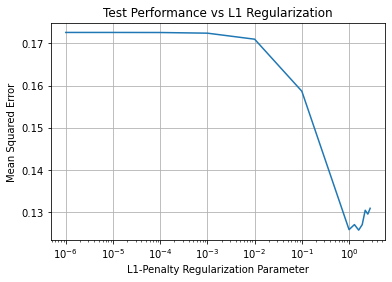

In [18]:
# Plot validation performance vs regularization parameter
fig, ax = plt.subplots()

ax.semilogx(df_error["Param_l1_reg"], df_error["mean_test_score"])
ax.grid()
ax.set_title("Test Performance vs L1 Regularization")
ax.set_xlabel("L1-Penalty Regularization Parameter")
ax.set_ylabel("Mean Squared Error")

In [19]:
#Plot of the prediction functions
pred_fns = []
x = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))
name = "Target Parameter Values (i.e. Bayes Optimal)"
pred_fns.append({"name":name, "coefs":coefs_true, "preds": target_fn(x) })

l1regs = [0.01, 0.1, 1]
X = featurize(x)
for l1reg in l1regs:
    lasso_regression_estimator, _ = random_coord_descent_2(X_train, l1reg)
    name = "Lasso with L1Reg="+str(l1reg)
    pred_fns.append({"name":name,
                         "coefs":lasso_regression_estimator,
                         "preds": np.dot(X,lasso_regression_estimator) })

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


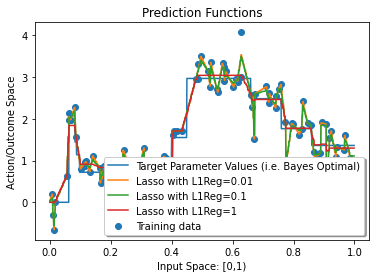

In [20]:
fig, ax = plt.subplots()
ax.set_xlabel('Input Space: [0,1)')
ax.set_ylabel('Action/Outcome Space')
ax.set_title("Prediction Functions")
plt.scatter(x_train, y_train, label='Training data')
for i in range(len(pred_fns)):
    ax.plot(x, pred_fns[i]["preds"], label=pred_fns[i]["name"])
legend = ax.legend(loc='best', shadow=True)

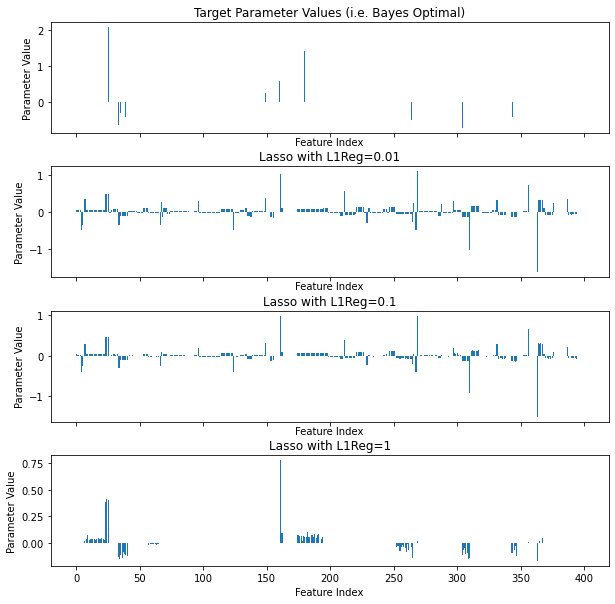

In [21]:
fig, axs = plt.subplots(len(pred_fns),1, sharex=True, figsize=(10,10))
num_ftrs = len(pred_fns[0]["coefs"])
for i in range(len(pred_fns)):
    title = pred_fns[i]["name"]
    coef_vals = pred_fns[i]["coefs"]
    axs[i].bar(range(num_ftrs), coef_vals)
    axs[i].set_xlabel('Feature Index')
    axs[i].set_ylabel('Parameter Value')
    axs[i].set_title(title)

fig.subplots_adjust(hspace=0.3)

The plot of the lasso coefficients for the optimal validation performance (l1reg =1.3) shows a lot of sparsity in the parameters, and the remaining parameters are generally centred around the target parameters values (same sign but different amplitude). This result is very different from the one obtained with the optimized ridge regression model, where no sparsity in the parameters was observed.
The best model found was a lasso regression with l1 penality equal to 1.6. The algorithm providing the best results on the validation set was random coordinate descent initialized with the ridge solution. The MSE on the validation set was equal to 0.125714.

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


converged
converged
converged


No handles with labels found to put in legend.


(4.76038522331588e-07,
 5.881876925182203,
 -1.7812029811999597,
 1.2296539073415866)

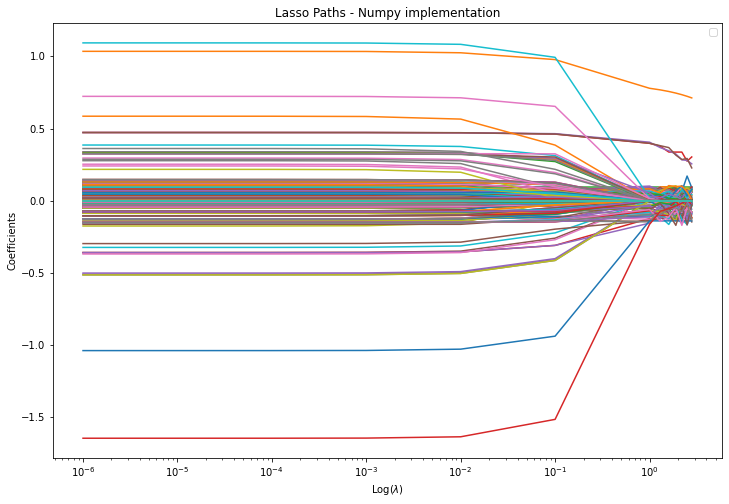

In [22]:
#Range of lambda values
l1_reg_arr = np.unique(np.concatenate((10.**np.arange(-6,1,1), np.arange(1,3,.3))))

#Initialize values
w_history = []

#Run lasso regression for each lambda
for l1_reg in l1_reg_arr:
    w_random_coord, _ = random_coord_descent_2(X_train, l1_reg)
    w_history.append(w_random_coord)

#Stack into numpy array
w_lasso = np.stack(w_history).T

#Plot results
n,_ = w_lasso.shape
plt.figure(figsize = (12,8))

for i in range(n):
    plt.plot(l1_reg_arr, w_lasso[i])

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('Coefficients')
plt.title('Lasso Paths - Numpy implementation')
plt.legend()
plt.axis('tight')

4. Implement the homotopy method described above. Compute the Lasso solution for (at least) the regularization parameters in the set $\{\lambda = \lambda_{max}0.8^i|i= 0, ... , 29\}$ Plot the results (average validation loss vs $\lambda$).

In [23]:
#Cyclic coordinate descent using the homotopy method to optimize the hyperparameter lamda:

#Soft threshold function:
def soft(a,d):
    if a < -d:
        return (a + d)
    elif a > d:
        return (a - d)
    else:
        return 0

#Cyclic coordinate descent with a closed form solution:
def cyclic_coord_descent_homotopy(X_train, y_train, num_iters=1000, tol = 1e-8):
    """
    cyclic_coord_descent_homotopy implements the cyclic coordinate descent algorithm using warm starting. At each iteration,
    the algorithm increments the index j of the coordinate to minimize the weight vector over. 
    In each step, the coefficent w[j] is updated with the minimizer corresponding to that index, using 
    the soft threshold function.
    The function takes as input the training dataset (X and y), the hyperparameter lambda (l1_reg), the maximum number 
    of iterations, and the tolerance level. The stopping criteria are the tolerance level (until a pass  pass through 
    the coordinates reduces the objective function by less than 10^−8) and the max number of iterations.
    The algorithm is initialized with w = 0 and the optimization is done with lamda = lambda_max. Next, lambda is reduced
    and the optimization problem is solved using the previous optimal point as the starting point.
    
    """
    
    #Number of training examples, number of features
    m, D = X_train.shape
    
    #Initialize weights vector
    w_new = np.zeros(D)
    
    #Initialize lamda_max
    l1_reg_max = 2*np.max(np.abs(X_train.T @ y_train))
    
    #Initialize a and c
    a = np.zeros(D)
    c = np.zeros(D)
    
    #Initialize history of weight vector and l1_reg parameter
    w_history = []
    l1_reg_history = []
    
    #Loop over lambda values, starting at lambda max, each time decreasing it by a factor of 0.8^i
    for i in range(-1,30):
        if i == -1:
            l1_reg = l1_reg_max
        else:
            l1_reg = l1_reg_max*0.8**i
    
       
        l1_reg_history.append(l1_reg)
        w_store = w_new.copy()
        w_history.append(w_store)
        
        #Training loop :
        for j in range(num_iters):
            w_old = w_new.copy()
            
            #Loop over the coordinates:
            for k in range(D):
                a[k] = 2*X_train[:,k].T @ X_train[:,k]
                c[k] = 2*(X_train[:,k].T @ (y_train -  X_train@w_new + w_new[k] * X_train[:,k]))
                w_new[k] = soft(c[k]/a[k], l1_reg/a[k])
                
            convergence_criteria = np.abs(w_new - w_old)
        
            if np.all(convergence_criteria < tol):
                print('converged')
                break
        
    return w_new, w_history, l1_reg_history

In [24]:
w_homotopy, w_history_homotopy, l1_reg_history = cyclic_coord_descent_homotopy(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in double_scalars


converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged


Text(0, 0.5, 'Mean Squared Error')

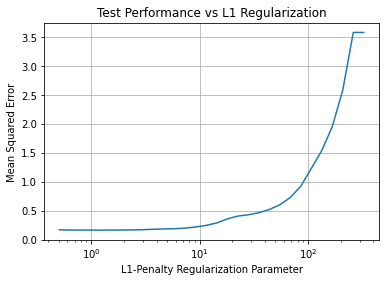

In [25]:
validation_loss = []

for w in w_history_homotopy:
    loss = compute_error(w, X_test, y_test)
    validation_loss.append(loss)

# Plot validation performance vs regularization parameter
fig, ax = plt.subplots()
ax.semilogx(l1_reg_history, validation_loss)
ax.grid()
ax.set_title("Test Performance vs L1 Regularization")
ax.set_xlabel("L1-Penalty Regularization Parameter")
ax.set_ylabel("Mean Squared Error")